# NHP1s - Non-human primate data master script (replication subject only)
# Cross-trial analysis (typical noise corr and variability analysis)

## Takuya Ito
#### 02/12/2019
#### Updated 03/27/20

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import multiprocessing as mp
import scipy.stats as stats
os.environ['OMP_NUM_THREADS'] = str(1)
import statsmodels.api as sm
import statsmodels.sandbox.stats.multicomp as mc
import seaborn as sns
plt.style.use("ggplot")
sns.set_style('whitegrid')
plt.rcParams["font.family"] = "FreeSans"
import pandas as pd
import sys
import h5py
import statsmodels.api as sm
import analysisNHP as analysis


# Set up data parameters

In [2]:
## All sessions (both subjects included)
sessions = ['100706','100730','100804','100820','100827','100913','100921','101024','101122','101128',
            '101207','101217','110110_01','110115_01','100724','100731','100817','100823','100828',
            '100915','101008','101027','101123','101202','101209','110106','110110_02','110120','100725',
            '100802','100818','100824','100907','100917','101009','101028','101124','101203','101210',
            '110107_01','110111_01','110121','100726','100803','100819','100826','100910','100920','101023',
            '101030','101127','101206','101216','110107_02','110111_02']

datadir = '/projects3/TaskFCMech/data/nhpData/'
tmin = -4000 # in ms
tmax = 4000 # in ms, this was my own doing

# Load in monkeyIDs
idfile = datadir + 'monkeyToSessionID.csv'
monkeyTable = pd.read_csv(idfile,delimiter=',')

replication_sessions = 0
monkeyID = {}
for i in range(1, len(sessions)+1):
    if i < 10:
        sess_str = 'session_ ' + str(i)
        name_str = 'name_ '  + str(i)
    else:
        sess_str = 'session_' + str(i)
        name_str = 'name_'  + str(i)
    
    session = str(monkeyTable[sess_str][0])
    name = monkeyTable[name_str][0]

    if name=='paula':
        replication_sessions += 1
        
    if session=='110111_02.mat': session = '110111_02'
        
    monkeyID[session] = name
    
exploratory_sessions = len(sessions) - replication_sessions
print 'Number of sessions with exploratory subject:', exploratory_sessions 
print 'Number of sessions with replication subject', replication_sessions
    
regions = ['PFC', 'FEF', 'LIP', 'MT', 'IT', 'V4']

Number of sessions with exploratory subject: 16
Number of sessions with replication subject 39


# 1.0 Load all sessions for replication subject

#### Load other meta-data associated with neurons + task info

#### Compute downsampled firing rate using 50ms bins and 10ms shift

In [3]:
analysis = reload(analysis)
spikes_binned = {}
mocolInfo = {}
areas = {}

sessioncount = 1
for session in sessions:
    # Sort exploratory v replication sessions by subject ID
    if monkeyID[session]!='paula': continue
    print 'Loading data for session', session, '|', sessioncount, '/', replication_sessions
    
    taskInfo = pd.read_csv(datadir + session + '_trialInfoAllTasks.csv')
    mocolTrials = np.where(taskInfo['task']=='mocol')[0]
    mocolInfo[session] = pd.read_csv(datadir + session + '_trialInfoMOCOL.csv')
    areas[session] = np.squeeze(pd.read_csv(datadir + session + '_areaIndices_v2.csv').values)
    
    # Find the number of neurons per area in the session
    unitInfo = pd.read_csv(datadir + session + '_unitInfo.csv')
    area_ind = np.asarray(unitInfo.area.values)
    
    ####
    h5f = h5py.File(datadir + session + '_perArea_v2.h5', 'r')
    # Columns for h5f are reversed between matlab and python | Output is time x neuron x trials
    spikes_binned[session] = analysis.spikeBinning(h5f['sta'][mocolTrials,:,:].T,binSize=50,shiftSize=10)
    h5f.close() 
    
    # Now normalize number of spikes per regions by number of neurons
    i = 0
    for area in areas[session]:
        ncells = len(np.where(area_ind==area)[0])
        spikes_binned[session][i,:,:] = np.divide(spikes_binned[session][i,:,:],ncells)
        i += 1
        
        
    sessioncount += 1
    

Loading data for session 100706 | 1 / 39
Loading data for session 100730 | 2 / 39
Loading data for session 100804 | 3 / 39
Loading data for session 100820 | 4 / 39
Loading data for session 100827 | 5 / 39
Loading data for session 101122 | 6 / 39
Loading data for session 101128 | 7 / 39
Loading data for session 101207 | 8 / 39
Loading data for session 101217 | 9 / 39
Loading data for session 110110_01 | 10 / 39
Loading data for session 110115_01 | 11 / 39
Loading data for session 100724 | 12 / 39
Loading data for session 100731 | 13 / 39
Loading data for session 100817 | 14 / 39
Loading data for session 100823 | 15 / 39
Loading data for session 100828 | 16 / 39
Loading data for session 101123 | 17 / 39
Loading data for session 101202 | 18 / 39
Loading data for session 101209 | 19 / 39
Loading data for session 110106 | 20 / 39
Loading data for session 110110_02 | 21 / 39
Loading data for session 100725 | 22 / 39
Loading data for session 100802 | 23 / 39
Loading data for session 100818 | 

# Perform main analyses for replication subject

In [4]:
analysis = reload(analysis)
dimReplications = {}
dimReplications['avg_post'] = []
dimReplications['avg_pre'] = []

rscReplications = {}
rscReplications['avg_post'] = []
rscReplications['avg_pre'] = []

covReplications = {}
covReplications['avg_post'] = []
covReplications['avg_pre'] = []

varReplications = {}
varReplications['avg_post'] = []
varReplications['avg_pre'] = []

frReplications = {}
frReplications['avg_post'] = []
frReplications['avg_pre'] = []


sesscount = 1
for session in sessions:
    # Sort exploratory v replication sessions by subject ID
    if monkeyID[session]!='paula': continue
    print 'Computing statistics for session', session, '|', sesscount, '/', replication_sessions
    
    ####
    tasksByTrial = mocolInfo[session]['rule'].astype(str)
    # Compute statistics for each task condition separately
    for condition in ['color','motion']:
        ind = np.where(tasksByTrial==condition)[0]
        cond_mocolInfo = mocolInfo[session].iloc[ind]
        
        tmp1, tmp2, tmp3, tmp4, tmp5 = analysis.computeCrossTrialStatistics5(spikes_binned[session][:,:,ind],cond_mocolInfo,areas[session],normalize=False)

        dimReplications['avg_post'].extend(tmp1['avg_post'])
        dimReplications['avg_pre'].extend(tmp1['avg_pre'])

        rscReplications['avg_post'].extend(tmp2['avg_post'])
        rscReplications['avg_pre'].extend(tmp2['avg_pre'])

        covReplications['avg_post'].extend(tmp3['avg_post'])
        covReplications['avg_pre'].extend(tmp3['avg_pre'])

        varReplications['avg_post'].extend(tmp4['avg_post'])
        varReplications['avg_pre'].extend(tmp4['avg_pre'])

        frReplications['avg_post'].extend(tmp5['avg_post'])
        frReplications['avg_pre'].extend(tmp5['avg_pre'])
    
    sesscount += 1


Computing statistics for session 100706 | 1 / 39


/usr/local/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:2569: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:2570: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Computing statistics for session 100730 | 2 / 39
Computing statistics for session 100804 | 3 / 39
Computing statistics for session 100820 | 4 / 39
Computing statistics for session 100827 | 5 / 39
Computing statistics for session 101122 | 6 / 39
Computing statistics for session 101128 | 7 / 39
Computing statistics for session 101207 | 8 / 39
Computing statistics for session 101217 | 9 / 39
Computing statistics for session 110110_01 | 10 / 39
Computing statistics for session 110115_01 | 11 / 39
Computing statistics for session 100724 | 12 / 39
Computing statistics for session 100731 | 13 / 39
Computing statistics for session 100817 | 14 / 39
Computing statistics for session 100823 | 15 / 39
Computing statistics for session 100828 | 16 / 39
Computing statistics for session 101123 | 17 / 39
Computing statistics for session 101202 | 18 / 39
Computing statistics for session 101209 | 19 / 39
Computing statistics for session 110106 | 20 / 39
Computing statistics for session 110110_02 | 21 / 39

## Compute statistics for exploratory subject

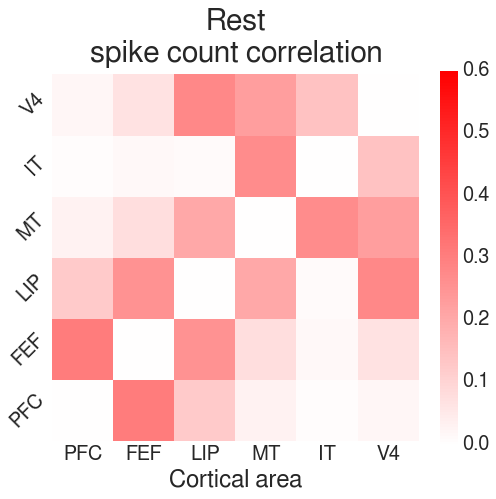

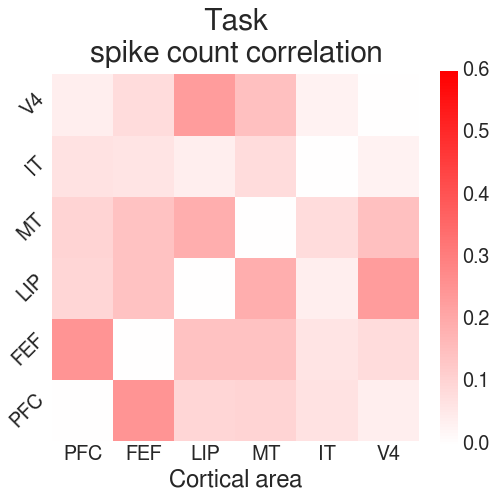

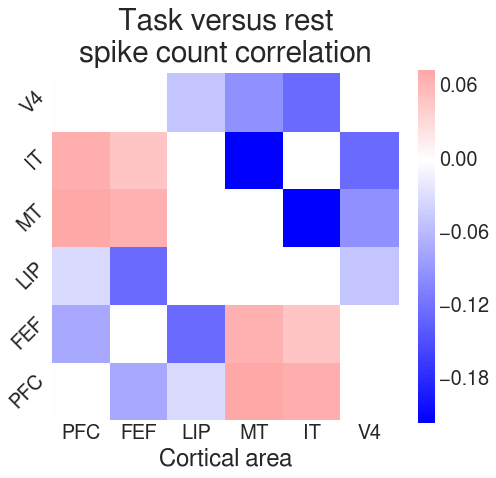

In [5]:
noiseCorrMat = np.zeros((len(regions),len(regions),4)) # corr, t, p, q
prePostCorrMat = np.zeros((len(regions),len(regions),2)) # Pre-stim X post-stim
for i in range(len(regions)):
    for j in range(len(regions)):
        if i == j: continue
        tmp = []
        tmppre = []
        tmppost = []
        for sess in range(len(rscReplications['avg_post'])):
            if np.isnan(rscReplications['avg_post'][sess][i,j]) or np.isnan(rscReplications['avg_pre'][sess][i,j]):
                continue
            tmp.append(np.arctanh(rscReplications['avg_post'][sess][i,j]) - np.arctanh(rscReplications['avg_pre'][sess][i,j]))
            tmppre.append(rscReplications['avg_pre'][sess][i,j])
            tmppost.append(rscReplications['avg_post'][sess][i,j])
        t, p = stats.ttest_1samp(tmp,0)
        noiseCorrMat[i,j,0] = np.mean(tmp)
        noiseCorrMat[i,j,1] = t
        noiseCorrMat[i,j,2] = p
        
        prePostCorrMat[i,j,0] = np.mean(tmppre)
        prePostCorrMat[i,j,1] = np.mean(tmppost)
        
triu_ind = np.triu_indices(noiseCorrMat.shape[0],k=1)
qs = mc.fdrcorrection0(noiseCorrMat[:,:,2][triu_ind])[0]
noiseCorrMat[:,:,3][triu_ind] = qs
noiseCorrMat[:,:,3] = noiseCorrMat[:,:,3] + noiseCorrMat[:,:,3].T

plt.figure(figsize=(7,7))
ax = sns.heatmap(prePostCorrMat[:,:,0],square=True,center=0, vmin=0, vmax=.6,cmap='bwr',cbar_kws={'fraction':0.046})
# ax = sns.heatmap(prePostCorrMat[:,:,0],square=True,center=0,cmap='bwr',cbar_kws={'fraction':0.046})
plt.xticks(np.arange(.5, len(regions)), regions, fontsize=20)
plt.yticks(np.arange(.5, len(regions)), regions, fontsize=20,rotation=45)
plt.xlabel('Cortical area',fontsize=24)
plt.title('Rest\nspike count correlation', fontsize=30,y=1.02)
# plt.ylabel('Cortical area',fontsize=24)
ax.invert_yaxis()
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=20)
plt.tight_layout()
# plt.savefig('NHP4s_RestCorr_Replication.pdf')

plt.figure(figsize=(7,7))
ax = sns.heatmap(prePostCorrMat[:,:,1],square=True,center=0,vmin=0, vmax=.6,cmap='bwr',cbar_kws={'fraction':0.046})
# ax = sns.heatmap(prePostCorrMat[:,:,1],square=True,center=0,cmap='bwr',cbar_kws={'fraction':0.046})
plt.xticks(np.arange(.5, len(regions)), regions, fontsize=20)
plt.yticks(np.arange(.5, len(regions)), regions, fontsize=20,rotation=45)
plt.xlabel('Cortical area',fontsize=24)
plt.title('Task\nspike count correlation', fontsize=30,y=1.02)
# plt.ylabel('Cortical area',fontsize=24)
ax.invert_yaxis()
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=20)
plt.tight_layout()
# plt.savefig('NHP4s_TaskCorr_Replication.pdf')

plt.figure(figsize=(7,7))
sig = np.multiply(noiseCorrMat[:,:,0], noiseCorrMat[:,:,3])
# sig = noiseCorrMat[:,:,0]
ax = sns.heatmap(sig,square=True,center=0,cmap='bwr',cbar_kws={'fraction':0.046})
plt.xticks(np.arange(.5, len(regions)), regions, fontsize=20)
plt.yticks(np.arange(.5, len(regions)), regions, fontsize=20,rotation=45)
plt.xlabel('Cortical area',fontsize=24)
plt.title('Task versus rest\nspike count correlation', fontsize=30,y=1.02)
# plt.ylabel('Cortical area',fontsize=24)
ax.invert_yaxis()
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=20)
plt.tight_layout()
# plt.savefig('NHP4s_DiffCorr_Replication.pdf')

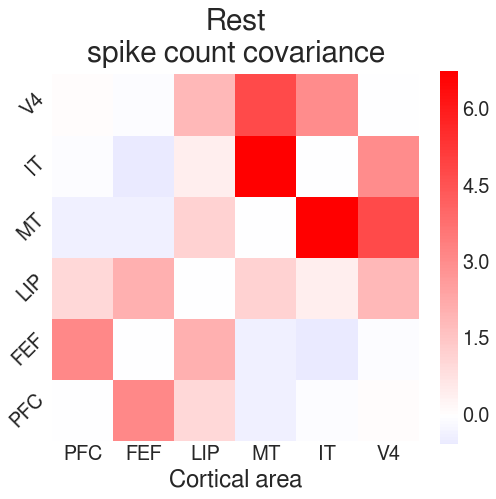

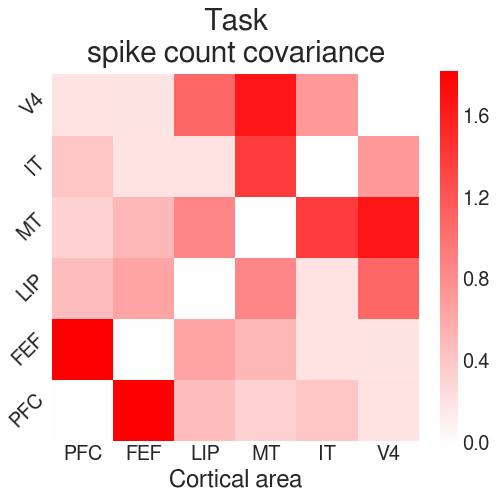

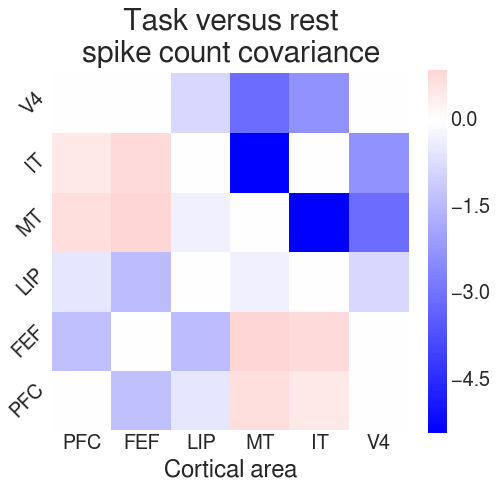

In [6]:
noiseCorrMat = np.zeros((len(regions),len(regions),4)) # corr, t, p, q
prePostCorrMat = np.zeros((len(regions),len(regions),2)) # Pre-stim X post-stim
for i in range(len(regions)):
    for j in range(len(regions)):
        if i == j: continue
        tmp = []
        tmppre = []
        tmppost = []
        for sess in range(len(covReplications['avg_post'])):
            if np.isnan(covReplications['avg_post'][sess][i,j]) or np.isnan(rscReplications['avg_pre'][sess][i,j]):
                continue
            tmp.append(covReplications['avg_post'][sess][i,j] - covReplications['avg_pre'][sess][i,j])
            tmppre.append(covReplications['avg_pre'][sess][i,j])
            tmppost.append(covReplications['avg_post'][sess][i,j])
        t, p = stats.ttest_1samp(tmp,0)
        noiseCorrMat[i,j,0] = np.mean(tmp)
        noiseCorrMat[i,j,1] = t
        noiseCorrMat[i,j,2] = p
        
        prePostCorrMat[i,j,0] = np.mean(tmppre)
        prePostCorrMat[i,j,1] = np.mean(tmppost)
        
triu_ind = np.triu_indices(noiseCorrMat.shape[0],k=1)
qs = mc.fdrcorrection0(noiseCorrMat[:,:,2][triu_ind])[0]
noiseCorrMat[:,:,3][triu_ind] = qs
noiseCorrMat[:,:,3] = noiseCorrMat[:,:,3] + noiseCorrMat[:,:,3].T

plt.figure(figsize=(7,7))
# ax = sns.heatmap(prePostCorrMat[:,:,0],square=True,center=0, vmin=0, vmax=.4,cmap='bwr',cbar_kws={'fraction':0.046})
ax = sns.heatmap(prePostCorrMat[:,:,0],square=True,center=0,cmap='bwr',cbar_kws={'fraction':0.046})
plt.xticks(np.arange(.5, len(regions)), regions, fontsize=20)
plt.yticks(np.arange(.5, len(regions)), regions, fontsize=20,rotation=45)
plt.xlabel('Cortical area',fontsize=24)
plt.title('Rest\nspike count covariance', fontsize=30,y=1.02)
# plt.ylabel('Cortical area',fontsize=24)
ax.invert_yaxis()
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=20)
plt.tight_layout()
# plt.savefig('NHP4s_RestCov_Replication.pdf')

plt.figure(figsize=(7,7))
# ax = sns.heatmap(prePostCorrMat[:,:,1],square=True,center=0,vmin=0, vmax=.4,cmap='bwr',cbar_kws={'fraction':0.046})
ax = sns.heatmap(prePostCorrMat[:,:,1],square=True,center=0,cmap='bwr',cbar_kws={'fraction':0.046})
plt.xticks(np.arange(.5, len(regions)), regions, fontsize=20)
plt.yticks(np.arange(.5, len(regions)), regions, fontsize=20,rotation=45)
plt.xlabel('Cortical area',fontsize=24)
plt.title('Task\nspike count covariance', fontsize=30,y=1.02)
# plt.ylabel('Cortical area',fontsize=24)
ax.invert_yaxis()
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=20)
plt.tight_layout()
# plt.savefig('NHP4s_TaskCov_Replication.pdf')

plt.figure(figsize=(7,7))
sig = np.multiply(noiseCorrMat[:,:,0], noiseCorrMat[:,:,3])
# sig = noiseCorrMat[:,:,0]
ax = sns.heatmap(sig,square=True,center=0,cmap='bwr',cbar_kws={'fraction':0.046})
plt.xticks(np.arange(.5, len(regions)), regions, fontsize=20)
plt.yticks(np.arange(.5, len(regions)), regions, fontsize=20,rotation=45)
plt.xlabel('Cortical area',fontsize=24)
plt.title('Task versus rest\nspike count covariance', fontsize=30,y=1.02)
# plt.ylabel('Cortical area',fontsize=24)
ax.invert_yaxis()
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=20)
plt.tight_layout()
# plt.savefig('NHP4s_DiffCov_Replication.pdf')

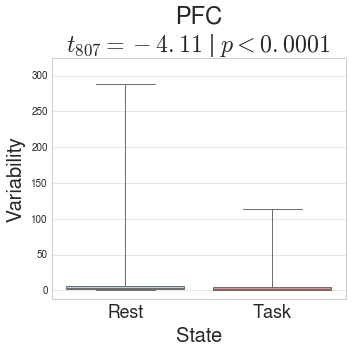

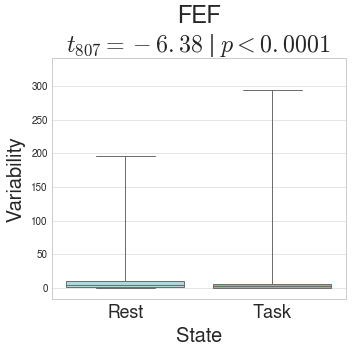

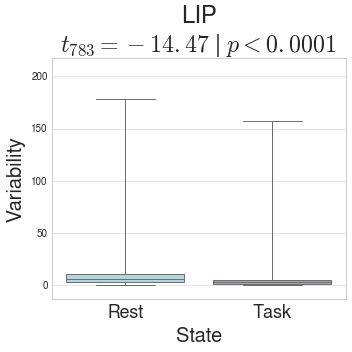

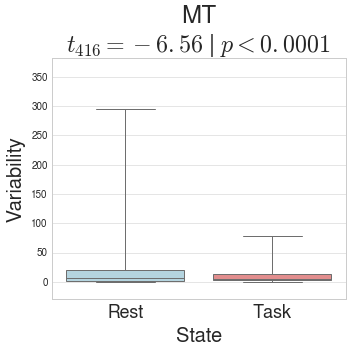

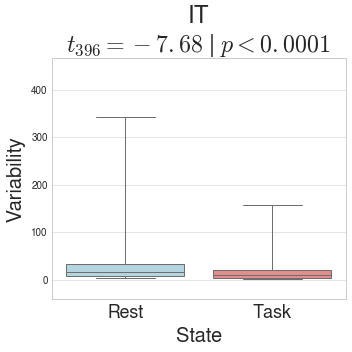

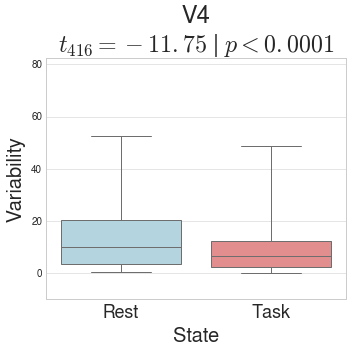

In [7]:
df_var = {}
ps = []
ts = []
dof = []
for i in range(len(regions)):
    area = regions[i]
    df_var[area] = {}
    df_var[area]['Variability'] = []
    df_var[area]['State'] = []

    tmp = []
    for sess in range(len(varReplications['avg_post'])):
        if varReplications['avg_post'][sess][i]!=0 and varReplications['avg_pre'][sess][i]!=0:
            tmp.append(varReplications['avg_post'][sess][i] - varReplications['avg_pre'][sess][i])
            df_var[area]['Variability'].append(varReplications['avg_pre'][sess][i])
            df_var[area]['State'].append('Rest')
            df_var[area]['Variability'].append(varReplications['avg_post'][sess][i])
            df_var[area]['State'].append('Task')
    
    t, p = stats.ttest_1samp(tmp,0)
    ps.append(p)
    ts.append(t)
    dof.append(len(tmp)-1)
qs = mc.fdrcorrection0(ps)[1]
df_var = pd.DataFrame(df_var)

for i in range(len(regions)):
    area = regions[i]
    t = ts[i]
    p = qs[i]
    df = dof[i]
    ## Now plot
    plt.figure(figsize=(5,5))
    sns.boxplot(x="State",y='Variability',
               palette=["#add8e6","#f08080"],
               data=df_var[area],whis=np.inf)
#     sns.stripplot(x="State",y='Variability',
#                palette=["#add8e6","#f08080"],
#                data=df_var[area], alpha=0.5)

    if p < 0.0001: 
        p = '$p < 0.0001$'
    else:
        p = '$p = ' + str(round(p,3)) + '$'
    plt.title(area + '\n$t_{' + str(df) + '} = ' + str(round(t,2)) + '$ | ' + p,fontname='FreeSans',fontsize=24)
    plt.ylabel('Variability',fontsize=20, fontname='FreeSans')
    plt.xlabel('State', fontsize=20,fontname='FreeSans')
    plt.xticks(fontsize=18,fontname='FreeSans')
    plt.ylim([np.min(df_var[area]['Variability'])-np.std(df_var[area]['Variability']),np.max(df_var[area]['Variability'])+3*np.std(df_var[area]['Variability'])]);
    plt.tight_layout()
#     plt.savefig('NHP4s_' + area + '_spkVariability_Replication.pdf')

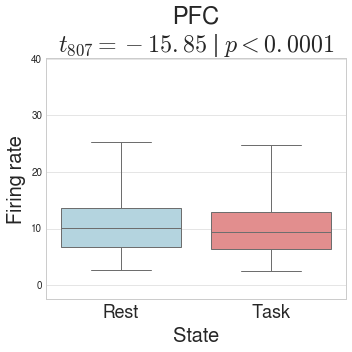

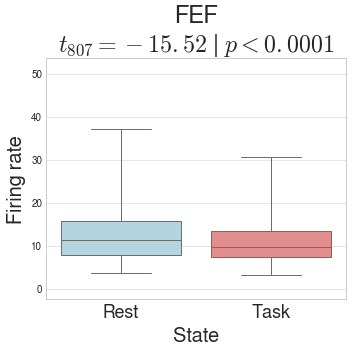

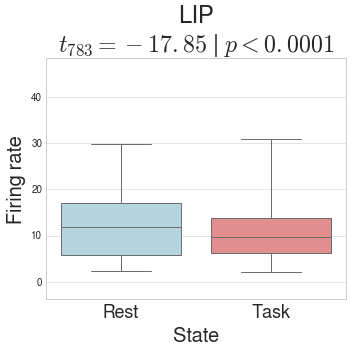

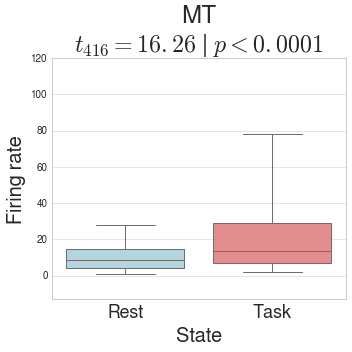

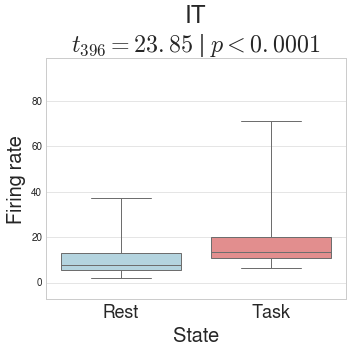

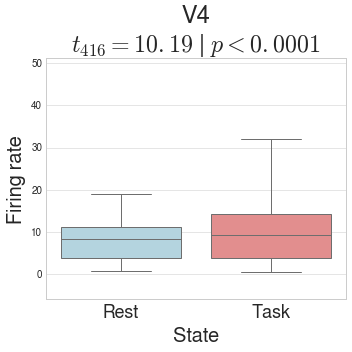

In [8]:
df_fr = {}
ps = []
ts = []
dof = []
for i in range(len(regions)):
    area = regions[i]
    df_fr[area] = {}
    df_fr[area]['Firing rate'] = []
    df_fr[area]['State'] = []

    tmp = []
    for sess in range(len(frReplications['avg_post'])):
        if varReplications['avg_post'][sess][i]!=0 and varReplications['avg_pre'][sess][i]!=0:
            tmp.append(frReplications['avg_post'][sess][i] - frReplications['avg_pre'][sess][i])
            df_fr[area]['Firing rate'].append(frReplications['avg_pre'][sess][i])
            df_fr[area]['State'].append('Rest')
            df_fr[area]['Firing rate'].append(frReplications['avg_post'][sess][i])
            df_fr[area]['State'].append('Task')
    
    t, p = stats.ttest_1samp(tmp,0)
    ps.append(p)
    ts.append(t)
    dof.append(len(tmp)-1)
    
qs = mc.fdrcorrection0(ps)[1]
df_fr = pd.DataFrame(df_fr)

for i in range(len(regions)):
    area = regions[i]
    t = ts[i]
    p = qs[i]
    df = dof[i]

    ## Now plot
    plt.figure(figsize=(5,5))
    sns.boxplot(x="State",y='Firing rate',
               palette=["#add8e6","#f08080"],
               data=df_fr[area], whis=np.inf)
#     sns.swarmplot(x="State",y='Firing rate',
#                palette=["#add8e6","#f08080"],
#                data=df_fr[area], alpha=0.5)

    if p < 0.0001: 
        p = '$p < 0.0001$'
    else:
        p = '$p = ' + str(round(p,3)) + '$'
    plt.title(area + '\n$t_{' + str(df) + '} = ' + str(round(t,2)) + '$ | ' + p,fontsize=24)
    plt.ylabel('Firing rate',fontsize=20)
    plt.xlabel('State', fontsize=20)
    plt.xticks(fontsize=18)
    plt.ylim([np.min(df_fr[area]['Firing rate'])-np.std(df_fr[area]['Firing rate']),np.max(df_fr[area]['Firing rate'])+3*np.std(df_fr[area]['Firing rate'])]);
    plt.tight_layout()
#     plt.savefig('NHP4s_FR_TaskVRest.pdf')

In [9]:
for area in df_var.keys():
    tmpsd = pd.DataFrame(dict(df_var[area]))
    tmpsd = tmpsd.loc[tmpsd['State']=='Task']
    tmpfr = pd.DataFrame(dict(df_fr[area]))
    tmpfr = tmpfr.loc[tmpfr['State']=='Task']

    print(area, stats.spearmanr(tmpsd['Variability'],np.abs(tmpfr['Firing rate'])))

('FEF', SpearmanrResult(correlation=0.82938570967302083, pvalue=5.5064831634046859e-206))
('IT', SpearmanrResult(correlation=0.67360982455978857, pvalue=8.0990055963508983e-54))
('LIP', SpearmanrResult(correlation=0.67440737038647369, pvalue=4.0838496388569783e-105))
('MT', SpearmanrResult(correlation=0.85544304710813623, pvalue=1.1777542232908366e-120))
('PFC', SpearmanrResult(correlation=0.75981910780396178, pvalue=7.0493244391650309e-153))
('V4', SpearmanrResult(correlation=0.75433653813055557, pvalue=7.3013016480887842e-78))


# Perform global analyses (i.e., averaged across all recordings)

In [10]:
globalSpkCorr = []
globalVar = []
globalFR = []

sesscount = 0
for trial in range(len(varReplications['avg_pre'])):
    
    tmp_rsc = np.zeros((2,))
    tmp_SD = np.zeros((2,))
    tmp_FR = np.zeros((2,))
    
    zero_ind = np.where(varReplications['avg_post'][trial]!=0)[0]
    
    tmp_SD[0] = np.mean(varReplications['avg_pre'][trial][zero_ind])
    tmp_SD[1] = np.mean(varReplications['avg_post'][trial][zero_ind])
    globalVar.append(tmp_SD)
    
    tmp_FR[0] = np.mean(frReplications['avg_pre'][trial][zero_ind])
    tmp_FR[1] = np.mean(frReplications['avg_post'][trial][zero_ind])
    globalFR.append(tmp_FR)
    
    zero_ind.shape = (len(zero_ind),1)
    np.fill_diagonal(rscReplications['avg_pre'][trial],0)
    np.fill_diagonal(rscReplications['avg_post'][trial],0)
    tmp_rsc[0] = np.mean(rscReplications['avg_pre'][trial][zero_ind,zero_ind.T])
    tmp_rsc[1] = np.mean(rscReplications['avg_post'][trial][zero_ind,zero_ind.T])
    globalSpkCorr.append(tmp_rsc)
    
    sesscount += 1
    
globalSpkCorr = np.asarray(globalSpkCorr)
globalVar = np.asarray(globalVar)
globalFR = np.asarray(globalFR)

### Plot

Dimensionality Post- vs. Pre-stim:
Dim diff: 0.261568914943
	t = 12.999 | p = 3.25542930709e-35
SpikeCountCorr Post- vs. Pre-stim:
SpkCorr diff: -0.0425756141768
	t = -9.082 | p = 8.08942495105e-19
Var variability Post- vs. Pre-stim:
Var diff: -5.36595116385
	t = -13.453 | p = 2.262707125e-37
Firing rate Post- vs. Pre-stim:
FR diff: 0.495581003015
	t = 3.93 | p = 9.23548222203e-05


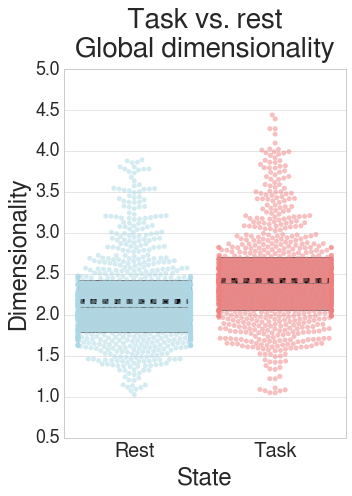

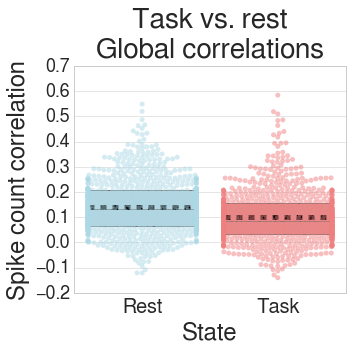

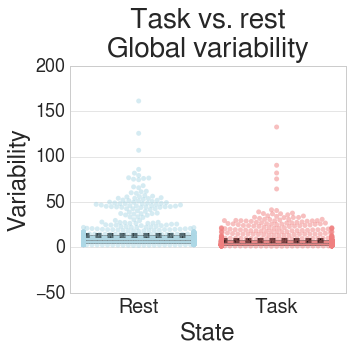

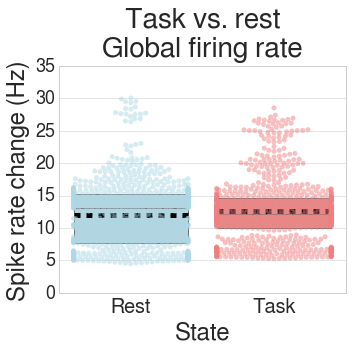

In [11]:
t, p = stats.ttest_rel(dimReplications['avg_post'],dimReplications['avg_pre'])
print 'Dimensionality Post- vs. Pre-stim:'
print 'Dim diff:', np.mean(dimReplications['avg_post']) - np.mean(dimReplications['avg_pre'])
print '\tt =', round(t,3), '| p =', p

plt.figure(figsize=(5,7))
sns.swarmplot(data=[dimReplications['avg_pre'], dimReplications['avg_post']],
           palette=["#add8e6","#f08080"],alpha=0.5)
sns.boxplot(data=[dimReplications['avg_pre'], dimReplications['avg_post']],
           palette=["#add8e6","#f08080"],
           meanline=True,showmeans=True,meanprops={'linewidth':5,'color':'k','linestyle':'--'},
           medianprops={'linestyle':'-'},sym='',whis=0)
df = len(dimReplications['avg_post'])-1
plt.title('Task vs. rest\nGlobal dimensionality',fontsize=28, y=1.02)
plt.ylabel('Dimensionality',fontsize=24)
plt.xticks(np.arange(0,2),['Rest', 'Task'], fontsize=20)
plt.yticks(fontsize=18)
plt.xlabel('State', fontsize=24)
# plt.ylim([np.min(dimReplications['avg_post'])-np.std(dimReplications['avg_post']),np.max(dimReplications['avg_post'])+1*np.std(dimReplications['avg_post'])]);
plt.tight_layout()
# plt.savefig('NHP4s_' + 'globalDim_Replication.jpg',dpi=150)

t, p = stats.ttest_rel(globalSpkCorr[:,1],globalSpkCorr[:,0])
print 'SpikeCountCorr Post- vs. Pre-stim:'
print 'SpkCorr diff:', np.mean(globalSpkCorr[:,1]) - np.mean(globalSpkCorr[:,0])
print '\tt =', round(t,3), '| p =', p

plt.figure(figsize=(5,5))
sns.swarmplot(data=[np.tanh(globalSpkCorr[:,0]), np.tanh(globalSpkCorr[:,1])],
           palette=["#add8e6","#f08080"], alpha=0.5)
sns.boxplot(data=[np.tanh(globalSpkCorr[:,0]), np.tanh(globalSpkCorr[:,1])],
           palette=["#add8e6","#f08080"],
           meanline=True,showmeans=True,meanprops={'linewidth':5,'color':'k','linestyle':'--'},
           medianprops={'linestyle':'-'},sym='',whis=0)
df = len(rscReplications['avg_post'])-1
plt.title('Task vs. rest\nGlobal correlations',fontsize=28, y=1.02)
plt.ylabel('Spike count correlation',fontsize=24)
plt.xticks(np.arange(0,2),['Rest', 'Task'], fontsize=20)
plt.yticks(fontsize=18)
plt.xlabel('State', fontsize=24)
# plt.ylim([np.min(globalSpkCorr[:,1])-np.std(globalSpkCorr[:,1]),np.max(globalSpkCorr[:,0])+1*np.std(globalSpkCorr[:,1])]);
plt.tight_layout()
# plt.savefig('NHP4s_' + 'globalSpkCorr_Replication.jpg',dpi=150)


t, p = stats.ttest_rel(globalVar[:,1],globalVar[:,0])
print 'Var variability Post- vs. Pre-stim:'
print 'Var diff:', np.mean(globalVar[:,1]) - np.mean(globalVar[:,0])
print '\tt =', round(t,3), '| p =', p

plt.figure(figsize=(5,5))
sns.swarmplot(data=[globalVar[:,0], globalVar[:,1]],
           palette=["#add8e6","#f08080"], alpha=0.5)
sns.boxplot(data=[globalVar[:,0], globalVar[:,1]],
           palette=["#add8e6","#f08080"],
           meanline=True,showmeans=True,meanprops={'linewidth':5,'color':'k','linestyle':'--'},
           medianprops={'linestyle':'-'},sym='',whis=0)
df = len(rscReplications['avg_post'])-1
plt.title('Task vs. rest\nGlobal variability',fontsize=28, y=1.02)
plt.ylabel('Variability',fontsize=24)
plt.xticks(np.arange(0,2),['Rest', 'Task'], fontsize=20)
plt.yticks(fontsize=18)
plt.xlabel('State', fontsize=24)
# plt.ylim([np.min(globalVar[:,1])-np.std(globalVar[:,1]),np.max(globalVar[:,0])+1*np.std(globalVar[:,0])]);
# plt.ylim([-100000,500000]);
plt.tight_layout()
# plt.savefig('NHP4s_' + 'globalVar_Replication.jpg',dpi=150)


t, p = stats.ttest_rel(globalFR[:,1],globalFR[:,0])
print 'Firing rate Post- vs. Pre-stim:'
print 'FR diff:', np.mean(globalFR[:,1]) - np.mean(globalFR[:,0])
print '\tt =', round(t,3), '| p =', p

plt.figure(figsize=(5,5))
sns.swarmplot(data=[globalFR[:,0], globalFR[:,1]],
           palette=["#add8e6","#f08080"], alpha=0.5)
sns.boxplot(data=[globalFR[:,0], globalFR[:,1]],
           palette=["#add8e6","#f08080"],
           meanline=True,showmeans=True,meanprops={'linewidth':5,'color':'k','linestyle':'--'},
           medianprops={'linestyle':'-'},sym='',whis=0)
df = len(frReplications['avg_post'])-1
plt.title('Task vs. rest\nGlobal firing rate',fontsize=28, y=1.02)
plt.ylabel('Spike rate change (Hz)',fontsize=24)
plt.xticks(np.arange(0,2),['Rest', 'Task'], fontsize=20)
plt.yticks(fontsize=18)
plt.xlabel('State', fontsize=24)
# plt.ylim([np.min(frReplications['avg_post'])-np.std(frReplications['avg_post']),np.max(frReplications['avg_post'])+1*np.std(frReplications['avg_post'])]);
plt.tight_layout()
# plt.savefig('NHP4s_' + 'globalFR_Replication.jpg',dpi=150)



# Scatter plots

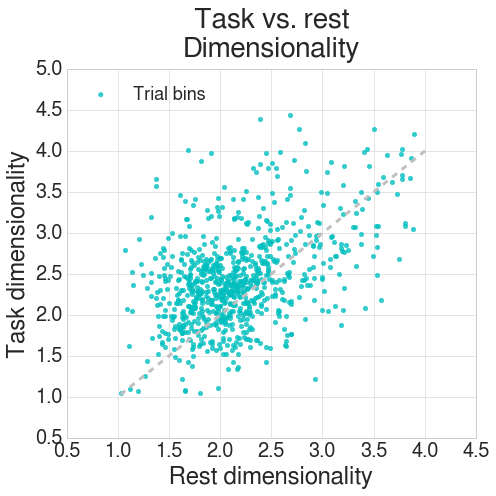

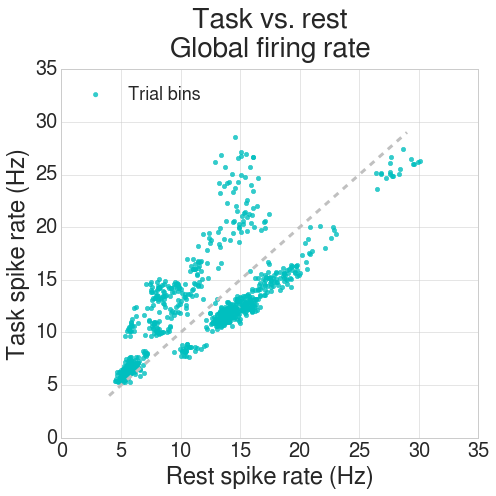

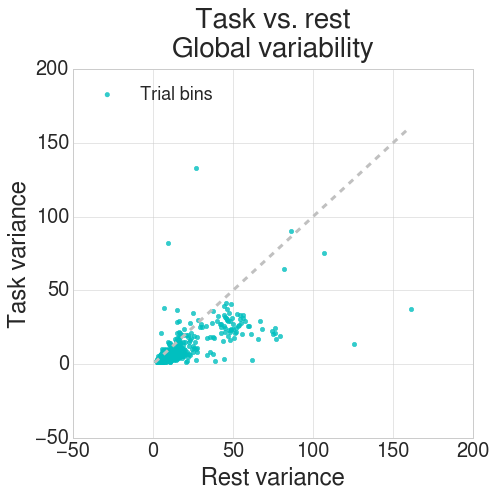

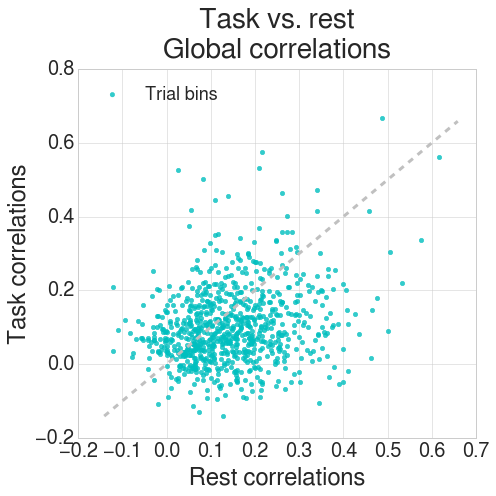

In [21]:
plt.figure(figsize=(7,7))
df = {}
df['Rest'] = []
df['Rest'].extend(dimReplications['avg_pre'])
df['Task'] = []
df['Task'].extend(dimReplications['avg_post'])
df = pd.DataFrame(data=df)
sns.regplot(x="Rest",y="Task",data=df,fit_reg=False,label='Trial bins',color='c')
minhz = np.min(df.values)
maxhz = np.max(df.values)
plt.plot(np.arange(minhz,maxhz),np.arange(minhz,maxhz),color='silver',linestyle='--',linewidth=3)
plt.title('Task vs. rest\nDimensionality',fontsize=28, y=1.02)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Task dimensionality', fontsize=24)
plt.xlabel('Rest dimensionality', fontsize=24)
plt.legend(loc=2, prop={'size': 18})
plt.tight_layout()
plt.savefig('NHP4s_' + 'globalDim_Scatter.jpg',dpi=150)


plt.figure(figsize=(7,7))
df = {}
df['Rest'] = []
df['Rest'].extend(globalFR[:,0])
df['Task'] = []
df['Task'].extend(globalFR[:,1])
df = pd.DataFrame(data=df)
sns.regplot(x="Rest",y="Task",data=df,fit_reg=False,label='Trial bins',color='c')
minhz = int(np.min(globalFR))
maxhz = int(np.max(globalFR))
plt.plot(np.arange(minhz,maxhz),np.arange(minhz,maxhz),color='silver',linestyle='--',linewidth=3)
plt.title('Task vs. rest\nGlobal firing rate',fontsize=28, y=1.02)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Task spike rate (Hz)', fontsize=24)
plt.xlabel('Rest spike rate (Hz)', fontsize=24)
plt.legend(loc=2, prop={'size': 18})
plt.tight_layout()
plt.savefig('NHP4s_' + 'globalFR_Scatter.jpg',dpi=150)


plt.figure(figsize=(7,7))
df = {}
df['Rest'] = []
df['Task'] = []
df['Rest'].extend(globalVar[:,0])
df['Task'].extend(globalVar[:,1])
df = pd.DataFrame(data=df)
sns.regplot(x="Rest",y="Task",data=df,fit_reg=False,label='Trial bins',color='c')
minhz = int(np.min(globalVar))
maxhz = int(np.max(globalVar))
plt.plot(np.arange(minhz,maxhz),np.arange(minhz,maxhz),color='silver',linestyle='--',linewidth=3)
plt.title('Task vs. rest\nGlobal variability',fontsize=28, y=1.02)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Task variance', fontsize=24)
plt.xlabel('Rest variance', fontsize=24)
plt.legend(loc=2, prop={'size': 18})
plt.tight_layout()
plt.savefig('NHP4s_' + 'globalVar_Scatter.jpg',dpi=150)


plt.figure(figsize=(7,7))
df = {}
df['Rest'] = []
df['Task'] = []
df['Rest'].extend(globalSpkCorr[:,0])
df['Task'].extend(globalSpkCorr[:,1])
df = pd.DataFrame(data=df)
sns.regplot(x="Rest",y="Task",data=df,fit_reg=False,label='Trial bins',color='c')
minhz = np.min(globalSpkCorr)
maxhz = np.max(globalSpkCorr)
plt.plot(np.arange(minhz,maxhz,0.01),np.arange(minhz,maxhz,0.01),color='silver',linestyle='--',linewidth=3)
plt.title('Task vs. rest\nGlobal correlations',fontsize=28, y=1.02)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Task correlations', fontsize=24)
plt.xlabel('Rest correlations', fontsize=24)
plt.legend(loc=2, prop={'size': 18})
plt.tight_layout()
plt.savefig('NHP4s_' + 'globalRSC_Scatter.jpg',dpi=150)